# Dogecoin Time-Series Analysis

### Set up environment

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error
from math import sqrt 
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

## Acquire and summarize data

Using daily-sampled historical data on Dogecoin to USD value from Investing.com.

In [2]:
df = pd.read_csv('DogecoinHistoricalTruncated.csv')

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 05, 2021",0.049016,0.052898,0.052898,0.049016,51.96B,-7.39%
1,"Feb 04, 2021",0.052930,0.037000,0.052930,0.036789,48.78B,41.69%
2,"Feb 03, 2021",0.037356,0.031388,0.037356,0.031388,12.96B,19.17%
3,"Feb 02, 2021",0.031347,0.034816,0.034816,0.030692,11.55B,-9.65%
4,"Feb 01, 2021",0.034694,0.036722,0.040650,0.034694,23.87B,-5.69%


In [4]:
# convert date column to datetime type
df.Date = pd.to_datetime(df.Date)
df.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %            object
dtype: object

In [5]:
# set ds as index and sort
# this is a very important step!
df = df.set_index('Date').sort_index()
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-01,0.003323,0.003558,0.003568,0.003323,1.03B,-6.67%
2020-12-02,0.003368,0.003324,0.003404,0.003324,591.00M,1.35%
2020-12-03,0.003428,0.003363,0.003439,0.003363,662.66M,1.78%
2020-12-04,0.003284,0.003422,0.003422,0.003284,572.32M,-4.20%
2020-12-05,0.003392,0.003281,0.003404,0.003281,369.45M,3.28%


Now that the data is acquired, let's look at its data types and summary statistics.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2020-12-01 to 2021-02-05
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     67 non-null     float64
 1   Open      67 non-null     float64
 2   High      67 non-null     float64
 3   Low       67 non-null     float64
 4   Vol.      67 non-null     object 
 5   Change %  67 non-null     object 
dtypes: float64(4), object(2)
memory usage: 3.7+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,67.0,0.010672,0.011989,0.003073,0.003743,0.008076,0.009742,0.052930
Open,67.0,0.009973,0.010959,0.003073,0.003638,0.007405,0.009579,0.052898
High,67.0,0.011812,0.014410,0.003113,0.003909,0.008351,0.009995,0.071812
Low,67.0,0.009213,0.009641,0.003058,0.003556,0.006835,0.009075,0.049016


In [8]:
df.shape

(67, 6)

## Prepare the data

Rename columns for readability and ease of calling.

In [9]:
df = df.rename(columns={'Vol.' : 'Volume'})
df = df.rename(columns={'Change %' : 'PercentChange'})

Appropriately convert strings to numericals.

In [10]:
df.head()

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2020-12-01,0.003323,0.003558,0.003568,0.003323,1.03B,-6.67%
2020-12-02,0.003368,0.003324,0.003404,0.003324,591.00M,1.35%
2020-12-03,0.003428,0.003363,0.003439,0.003363,662.66M,1.78%
2020-12-04,0.003284,0.003422,0.003422,0.003284,572.32M,-4.20%
2020-12-05,0.003392,0.003281,0.003404,0.003281,369.45M,3.28%


In [11]:
def mb_to_mbillion(string):
    if string[-1] == 'B':
        string = string[:-1]
        num = float(string) * 1_000_000_000
    elif string[-1] == 'M':
        string = string[:-1]
        num = float(string) * 1_000_000
    return num

df.Volume = df.Volume.apply(mb_to_mbillion)

In [12]:
def handle_percent(string):
    string = string[:-1]
    num = float(string)
    return num

df.PercentChange = df.PercentChange.apply(handle_percent)

In [13]:
df.dtypes

Price            float64
Open             float64
High             float64
Low              float64
Volume           float64
PercentChange    float64
dtype: object

In [14]:
df.head()

,Price,Open,High,Low,Volume,PercentChange
Date,,,,,,
2020-12-01,0.003323,0.003558,0.003568,0.003323,1.030000e+09,-6.67
2020-12-02,0.003368,0.003324,0.003404,0.003324,5.910000e+08,1.35
2020-12-03,0.003428,0.003363,0.003439,0.003363,6.626600e+08,1.78
2020-12-04,0.003284,0.003422,0.003422,0.003284,5.723200e+08,-4.20
2020-12-05,0.003392,0.003281,0.003404,0.003281,3.694500e+08,3.28


Conversions successful.

## Acquire and prepare minute OHLCV data

After I split the data and plotted it, I realized that there is not enough data to split how I want, as this dataset is only daily.

So, I am now going to acquire minute-by-minute Dogecoin/USD data. It's a little messier than the other dataset, but the time and effort will be well worth it.

In [15]:
df = pd.read_csv('DOGEBUSD.csv', header=None, sep='|')
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1596085200,0.003158,0.003158,0.003158,0.003158,3200,10,3200,10,1
1,1596085260,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0
2,1596085320,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0
3,1596085380,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0
4,1596085440,0.003158,0.003158,0.003158,0.003158,0,0,0,0,0


There was no documentation I could find on what each column represents.

However, I can use domain knowledge and process of eliminaton to make educated guesses on which columns are what.

In [16]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.812550e+05,281255.000000,281255.000000,281255.000000,281255.000000,2.812550e+05,2.812550e+05,2.812550e+05,2.812550e+05,281255.000000
mean,1.604529e+09,0.007043,0.007062,0.007022,0.007043,1.543448e+05,2.609986e+03,7.882887e+04,5.242457e+03,12.580985
std,4.878725e+06,0.012328,0.012393,0.012257,0.012328,8.553917e+05,1.895915e+04,4.547398e+05,3.616882e+04,72.885271
min,1.596085e+09,0.002459,0.002459,0.002459,0.002459,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.600304e+09,0.002734,0.002734,0.002734,0.002734,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.604523e+09,0.003281,0.003282,0.003281,0.003281,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,1.608759e+09,0.004474,0.004475,0.004472,0.004474,2.747000e+03,0.000000e+00,0.000000e+00,1.300000e+01,1.000000
max,1.612982e+09,0.086889,0.087381,0.085020,0.086888,4.248405e+07,1.403784e+06,2.364880e+07,1.908171e+06,3431.000000


In [17]:
# rename columns and drop columns I can't figure out for now

# I will ask a stockbroker at some point to see if they can help me determine what the last few fields are.

col_dict = {
    0: 'SecondsSinceEpoch',
    1: 'Open',
    2: 'High',
    3: 'Low',
    4: 'Close',
    5: 'Volume'
}

df = df.drop(columns=[6, 7, 8, 9])
df = df.rename(columns=col_dict)

df.head()

,SecondsSinceEpoch,Open,High,Low,Close,Volume
0,1596085200,0.003158,0.003158,0.003158,0.003158,3200
1,1596085260,0.003158,0.003158,0.003158,0.003158,0
2,1596085320,0.003158,0.003158,0.003158,0.003158,0
3,1596085380,0.003158,0.003158,0.003158,0.003158,0
4,1596085440,0.003158,0.003158,0.003158,0.003158,0


Now I just need to check data types, convert ```SecondsSinceEpoch``` to datetime, set the index to be datetime, and check for nulls.

In [18]:
# check data types
df.dtypes

SecondsSinceEpoch      int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
dtype: object

In [19]:
# convert SecondsSinceEpoch to datetime
def convert_seconds_since_epoch(sec):
    time = datetime.utcfromtimestamp(sec)
    return time

df.SecondsSinceEpoch = df.SecondsSinceEpoch.apply(convert_seconds_since_epoch)

In [20]:
# set index to SecondsSinceEpoch (and rename to Date)

df = df.rename(columns={'SecondsSinceEpoch': 'Date'})

df = df.set_index('Date')

In [21]:
# check that these changes were successful
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-30 05:00:00,0.003158,0.003158,0.003158,0.003158,3200
2020-07-30 05:01:00,0.003158,0.003158,0.003158,0.003158,0
2020-07-30 05:02:00,0.003158,0.003158,0.003158,0.003158,0
2020-07-30 05:03:00,0.003158,0.003158,0.003158,0.003158,0
2020-07-30 05:04:00,0.003158,0.003158,0.003158,0.003158,0


In [22]:
# finally, check for nulls
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

The data looks good to go!

### Summarize minute data

In [23]:
df.shape

(281255, 5)

This is 188 days worth of minute-to-minute Dogecoin/USD data.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281255 entries, 2020-07-30 05:00:00 to 2021-02-10 18:25:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    281255 non-null  float64
 1   High    281255 non-null  float64
 2   Low     281255 non-null  float64
 3   Close   281255 non-null  float64
 4   Volume  281255 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 12.9 MB


### Split the data

Now I will split the dataset into train, validate, and test since the goal of this project is to create a predictive model.

In [25]:
# get size of train
train_size = int(len(df) * .94)
train_size

264379

In [26]:
# get size of validate
validate_size = int(len(df) * .035)
validate_size

9843

In [27]:
# get size of test
test_size = int(len(df) - train_size - validate_size)
test_size

7033

In [28]:
# get end index of validate
validate_end_index = train_size + validate_size
validate_end_index

274222

In [29]:
# use the above values to split the df
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

I'll set the prediction target to be ```High``` because I want to predict the point at which it will be best for me to liquidate my Dogecoin into USD.

In [30]:
# set the prediction target variable, y
y_train = train.High
y_validate = validate.High
y_test = test.High

y_train.head()

Date
2020-07-30 05:00:00    0.003158
2020-07-30 05:01:00    0.003158
2020-07-30 05:02:00    0.003158
2020-07-30 05:03:00    0.003158
2020-07-30 05:04:00    0.003158
Name: High, dtype: float64

Now to verify the splits.

In [31]:
# Does the length of each df equate to the length of the original df?

print(len(train) + len(validate) + len(test) == len(df))

True


In [32]:
# Does the first row of original df equate to the first row of train?

print(df.head(1) == train.head(1))

                     Open  High   Low  Close  Volume
Date                                                
2020-07-30 05:00:00  True  True  True   True    True


In [33]:
# Is the last row of train the day before the first row of validate? And the same for validate to test?

pd.concat([train.tail(1), validate.head(1)])

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-30 01:09:00,0.046789,0.046826,0.046346,0.046571,3313708
2021-01-30 01:10:00,0.046500,0.047093,0.046487,0.047077,863252


In [34]:
pd.concat([validate.tail(1), test.head(1)])

,Open,High,Low,Close,Volume
Date,,,,,
2021-02-05 21:12:00,0.046116,0.046229,0.046112,0.046137,163889
2021-02-05 21:13:00,0.046202,0.046212,0.045962,0.046102,207296


In [35]:
# Is the last row of test the same as the last row of our original dataframe?

pd.concat([test.tail(1), df.tail(1)])

,Open,High,Low,Close,Volume
Date,,,,,
2021-02-10 18:25:00,0.074621,0.074761,0.074468,0.074761,133322
2021-02-10 18:25:00,0.074621,0.074761,0.074468,0.074761,133322


Splits successful. Onward to data exploration.

## Exploratory data analysis

First I'll plot the data, viewing where the data is split into train and test.

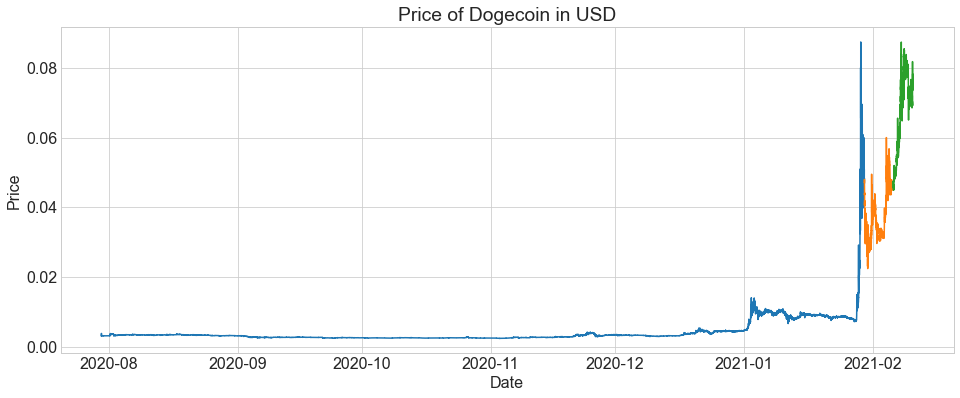

In [36]:
plt.figure(figsize=(16,6))
plt.plot(train['High'])
plt.plot(validate['High'])
plt.plot(test['High'])
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Price of Dogecoin in USD')
plt.show()

Plot the distribution of ```High```.

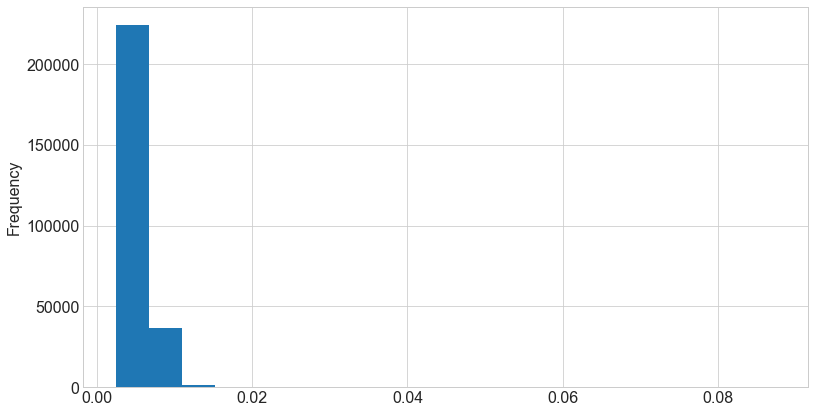

In [37]:
y_train.plot.hist(bins=20)

Plot the distribution of ```Volume```.

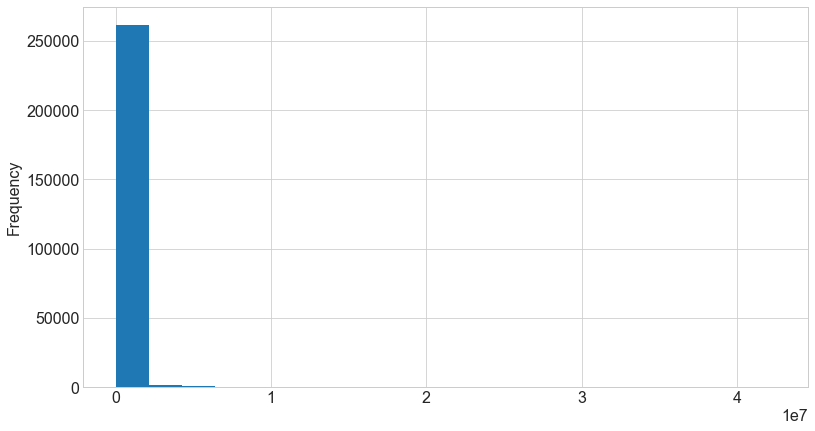

In [38]:
train.Volume.plot.hist(bins=20)

<ipython-input-39-9b5dff556f6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month


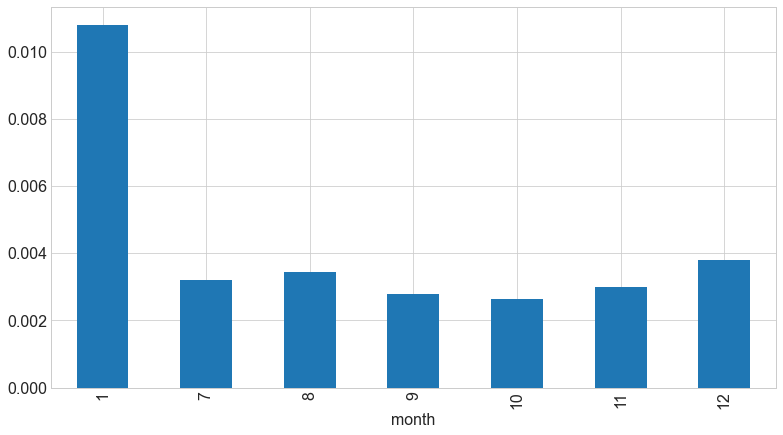

In [39]:
train['month'] = train.index.month

train.groupby('month').High.mean().plot.bar()

<ipython-input-40-daa6c0bc6a98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['day'] = train.index.day


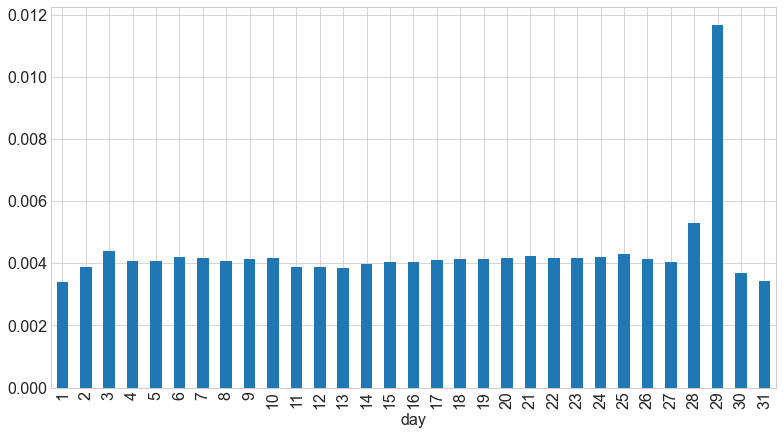

In [40]:
train['day'] = train.index.day

train.groupby('day').High.mean().plot.bar()

<ipython-input-41-9e8d4f532522>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekday'] = train.index.weekday


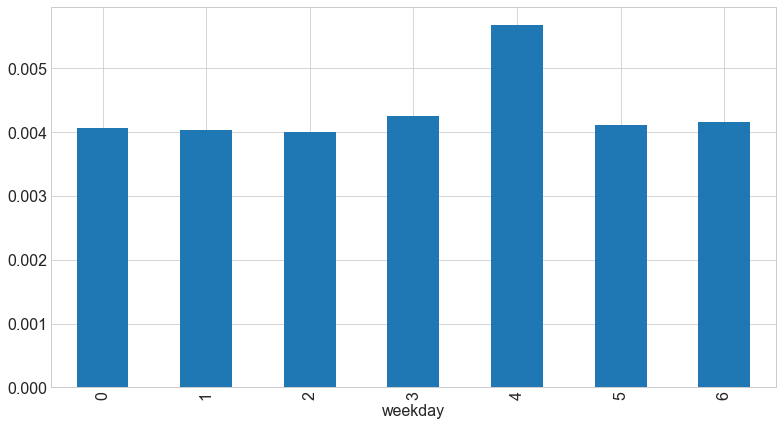

In [41]:
train['weekday'] = train.index.weekday

train.groupby('weekday').High.mean().plot.bar()

<ipython-input-42-62db68a75418>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['year'] = train.index.year


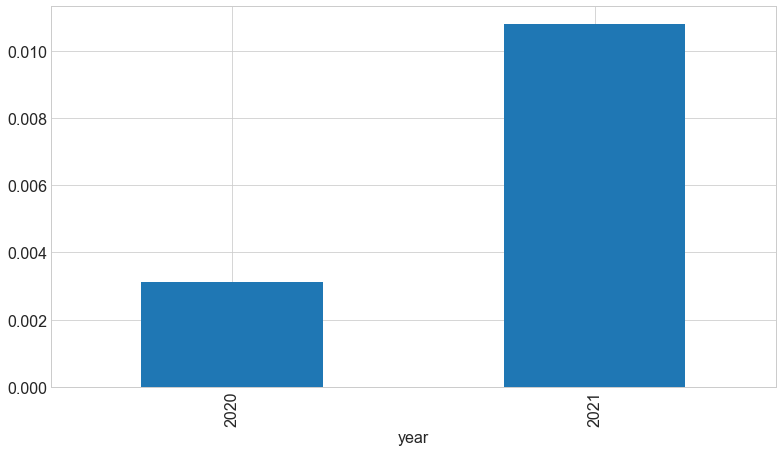

In [42]:
train['year'] = train.index.year

train.groupby('year').High.mean().plot.bar()

<ipython-input-43-10bf864d8c74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['hour'] = train.index.hour


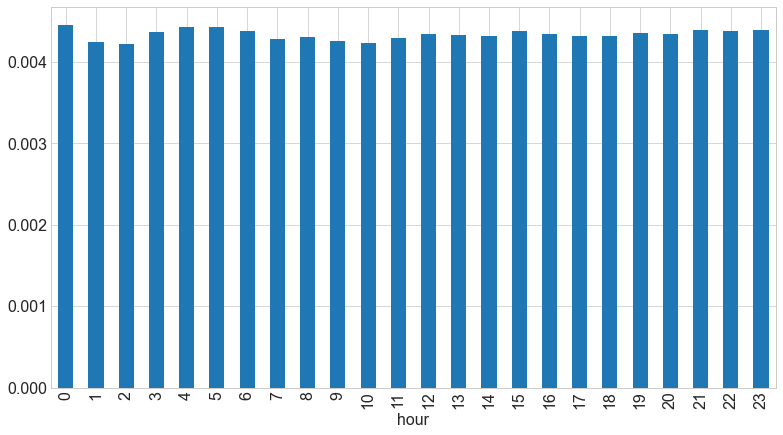

In [43]:
train['hour'] = train.index.hour
# this is in UTC
train.groupby('hour').High.mean().plot.bar()

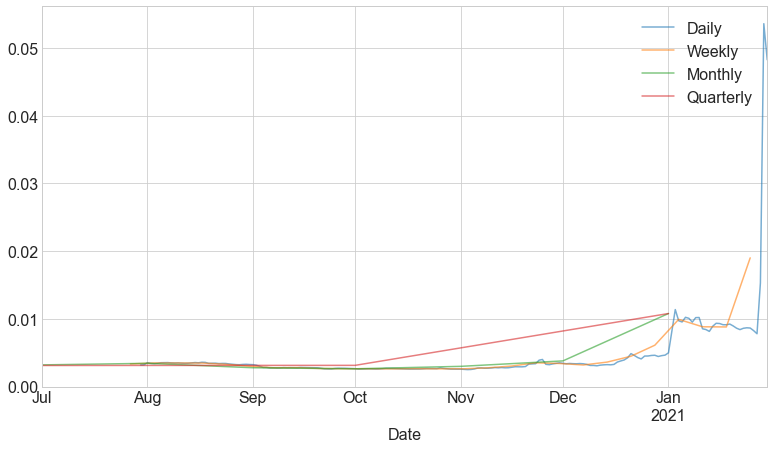

In [44]:
y_train.resample('D').mean().plot(alpha=.6, label='Daily')
y_train.resample('W').mean().plot(alpha=.6, label='Weekly')
y_train.resample('M').mean().plot(alpha=.6, label='Monthly')
y_train.resample('Q').mean().plot(alpha=.6, label='Quarterly')
plt.legend()

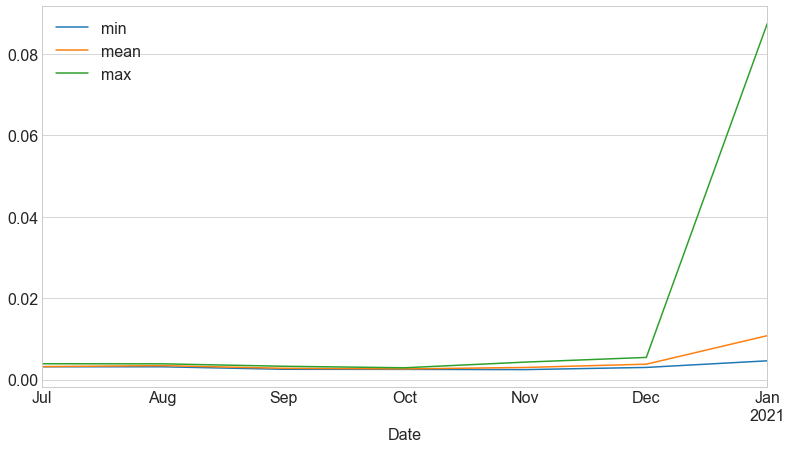

In [45]:
y_train.resample('M').agg(['min', 'mean', 'max']).plot()

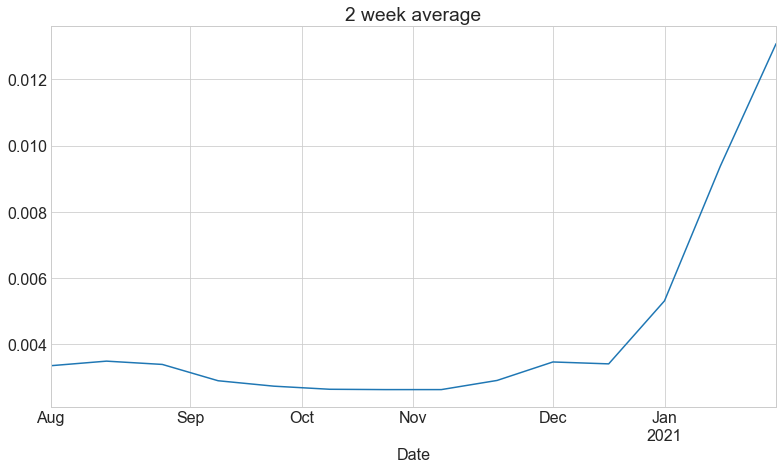

In [46]:
y_train.resample('2W').mean().plot(title='2 week average')

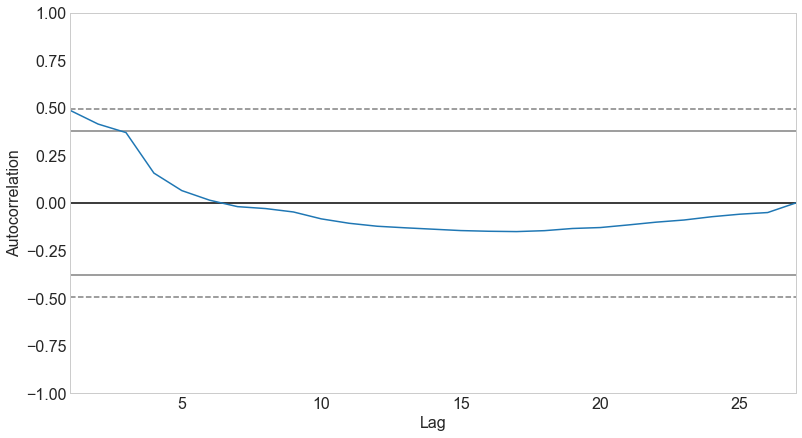

In [47]:
pd.plotting.autocorrelation_plot(train.High.resample('W').mean())

# Predictive Modeling

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

```evaluate()``` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [48]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

```plot_and_eval()``` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [49]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,8))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE:', rmse)
    plt.show()

Write ```append_eval_df(model_type)``` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our ```eval_df``` data frame object.

In [50]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Approaches

I'll be trying the following predictive approaches:

* Last Observed Value
* Simple Average
* Moving Average
* Holt's Linear Trend
* Previous Cycle

## Last Observed Value

In [51]:
# select last observed value
price = round(train['High'][-1:][0], 5)
price

0.04683

In [52]:
# add to predictions data frame
yhat_df = pd.DataFrame({'High': [price]}, 
                      index = validate.index)

yhat_df.head(3)

,High
Date,
2021-01-30 01:10:00,0.04683
2021-01-30 01:11:00,0.04683
2021-01-30 01:12:00,0.04683


### Plot Actual vs. Predicted Values

High -- RMSE: 0.012


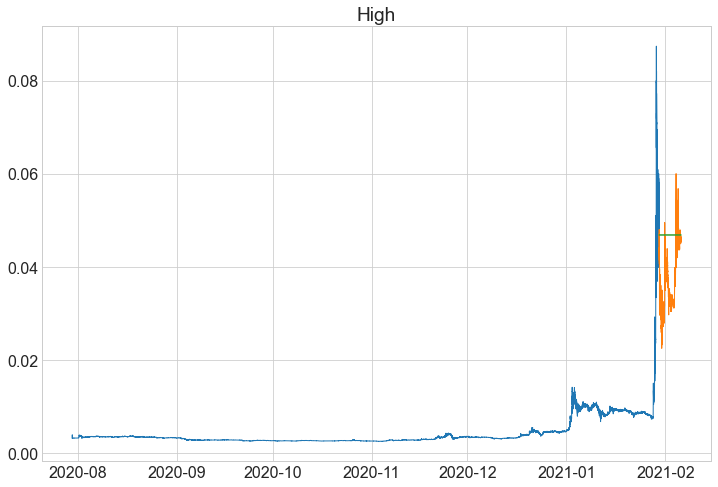

In [53]:
plot_and_eval('High')

### Evaluate

In [54]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'High')
eval_df

,model_type,target_var,rmse
0,last_observed_value,High,0.012


## Simple Average

In [55]:
# compute simple average
price = round(train['High'].mean(),5)
price

0.00434

In [56]:
# add to predictions data frame
yhat_df = pd.DataFrame({'High': [price]}, 
                      index = validate.index)

yhat_df.head(3)

,High
Date,
2021-01-30 01:10:00,0.00434
2021-01-30 01:11:00,0.00434
2021-01-30 01:12:00,0.00434


### Plot Actual vs. Predicted Values

High -- RMSE: 0.0336


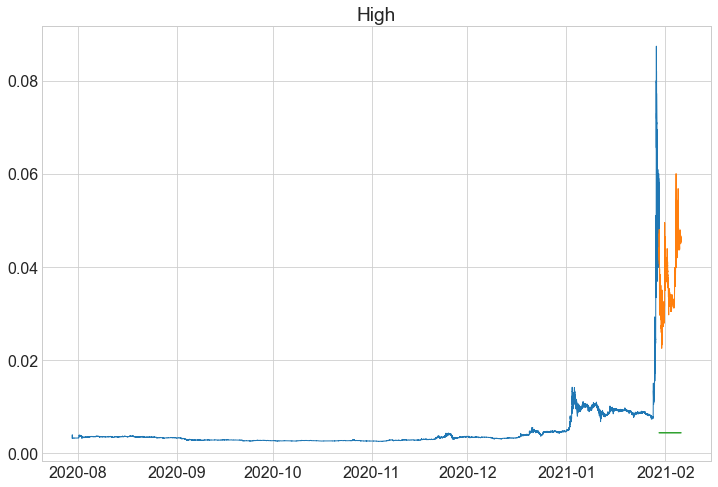

In [57]:
plot_and_eval('High')

### Evaluate

In [58]:
eval_df = append_eval_df(model_type='simple_average', target_var = 'High')
eval_df

,model_type,target_var,rmse
0,last_observed_value,High,0.0120
1,simple_average,High,0.0336


## Moving Averages

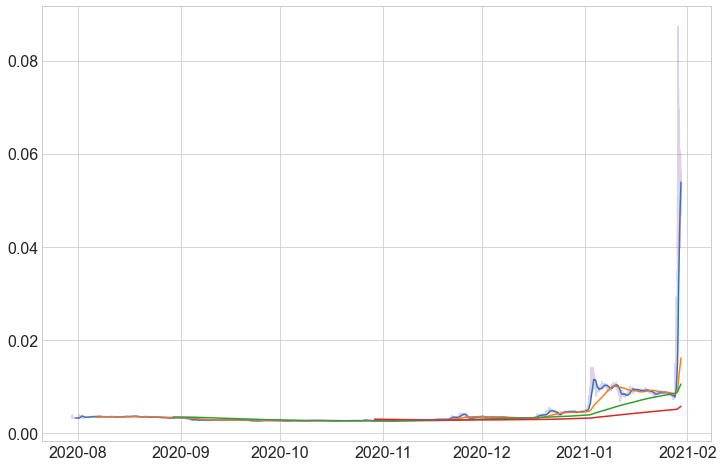

In [59]:
# plot moving averages
plt.figure(figsize=(12,8))
plt.plot(train['High'].rolling(1440).mean()) # Day
plt.plot(train['High'].rolling(10080).mean()) # Week
plt.plot(train['High'].rolling(43800).mean()) # Month
plt.plot(train['High'].rolling(131400).mean()) # 3 Months
plt.plot(train['High'], alpha=.3)

In [60]:
1440 / 1440

10080 / 1440

7.0

I'm going to use a rolling average of a week for my prediction.

In [61]:
period = 10080
prediction = round(train['High'].rolling(period).mean()[-1], 2)
print(prediction)

0.02


In [62]:
yhat_df = pd.DataFrame({'High': [prediction]}, index = validate.index)
yhat_df.head()

,High
Date,
2021-01-30 01:10:00,0.02
2021-01-30 01:11:00,0.02
2021-01-30 01:12:00,0.02
2021-01-30 01:13:00,0.02
2021-01-30 01:14:00,0.02


### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using the moving average of 1 week.

High -- RMSE: 0.0186


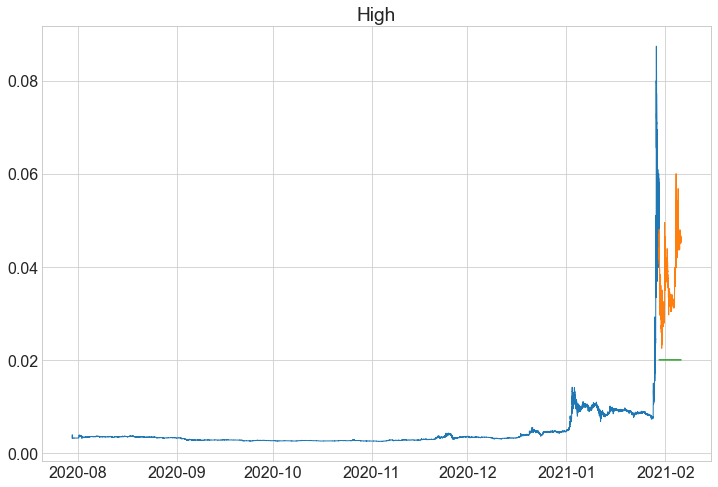

In [63]:
plot_and_eval('High')

### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to ```eval_df```.

In [64]:
periods = [1440, 10080, 43800, 131400]

for p in periods: 
    prediction = round(train['High'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'High': [prediction]}, index = validate.index)
    model_type = str(round(int(p / 1440), 0)) + 'day_moving_avg'
    eval_df = append_eval_df(model_type = model_type, target_var = 'High')

In [65]:
eval_df.sort_values(by='rmse', ascending=False)

,model_type,target_var,rmse
1,simple_average,High,0.0336
4,30day_moving_avg,High,0.0281
5,91day_moving_avg,High,0.0281
3,7day_moving_avg,High,0.0186
2,1day_moving_avg,High,0.0147
0,last_observed_value,High,0.0120


In [ ]:
## 

Note to self: Holidays = Elon Musk tweet days